# Description

Python notebook to calculate Quasigeostrophic PV inversion, including some idealized PV distributions.

Based on Matlab code by Greg Hakim, quickly translated to Python by Matt Barlow. Would benefit from being put into a more native python form.

Notebook history:
</Br> 30 Apr 2024: initial translation from Matlab
</Br> 29 Jan 2025: minor edits

Originally released under GNU General Public License version 3. http://www.gnu.org/licenses/gpl.html by G.J. Hakim, University of Washington

# import needed packages

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# set up

## define inverse laplacian function

In [91]:
def inv_laplacian(lbcxy, ubcxy, qxy, idn, dz, facx, facy):
    nlevs = qxy.shape[0]
    Ny = qxy.shape[1]
    Nx = qxy.shape[2]
    lmax = Ny // 2
    kmax = Nx // 2

    # map RHS and boundary conditions to Fourier space
    lbcsp = np.fft.fft2(lbcxy)
    ubcsp = np.fft.fft2(ubcxy)

    qsp = np.zeros((nlevs, 2*lmax, 2*kmax)).astype(complex)

#    qsp = np.fft.fft2(qxy, axes=(1, 2))
    for k in range(nlevs):
      qsp[k, :, :] = np.fft.fft2(np.squeeze(qxy[k, :, :]))

    facz = np.ones(nlevs)
    faczo = facz

#   add boundary condition to a copy of spectral RHS:
    if idn == 1: # Neumann boundary condition
        qsp[0, :, :] += (lbcsp / (facz[0] * dz))
        qsp[-1, :, :] -= (ubcsp / (facz[-1] * dz))
    elif idn == -1: # Dirichlet boundary condition
        qsp[0, :, :] -= (2 * lbcsp / (facz[0] * facz[0] * dz * dz))
        qsp[-1, :, :] -= (2 * ubcsp / (facz[-1] * facz[-1] * dz * dz))
    else:
        raise ValueError('Wrong specification of idn')

# tridiagonal matrix inversion for each (k,l)

    fsp = np.zeros((nlevs, Ny, Nx)).astype(complex)

    fbsp = np.zeros((2*lmax, 2*kmax)).astype(complex)
    ftsp = np.zeros((2*lmax, 2*kmax)).astype(complex)
    fzbsp = np.zeros((2*lmax, 2*kmax)).astype(complex)
    fztsp = np.zeros((2*lmax, 2*kmax)).astype(complex)

    for k in range(0, 2 * kmax):
        for l in range(0, 2 * lmax):
            ak, bl = get_waves(k, l, kmax, lmax, facx, facy)
            if ((k == 0) & (l == 0)):
              fbsp[l, k] = 0.
              ftsp[l, k] = 0.
              fsp[:, l, k] = 0.

            else:

              dd = np.diag(-1. * ((ak * ak) + (bl * bl) + (2. / (dz * dz))) * np.ones(nlevs))
              ud = np.diag((1 / (dz * dz)) * np.ones(nlevs-1), 1)
              ld = np.diag((1 / (dz * dz)) * np.ones(nlevs-1), -1)

              A = dd + ud + ld

              if idn == 1:
                  A[0, 0] = -1. * ((ak * ak) + (bl * bl) + (1 / (dz * dz)))
              elif idn == -1:
                  A[0, 0] = -1. * ((ak * ak) + (bl * bl) + (3 / (dz * dz)))

              A[-1, -1] = A[0, 0]

              psi = np.linalg.solve(A, qsp[:, l, k])

              fsp[:, l, k] = psi

              if idn == 1:
                  fbsp[l, k] = psi[0] - (0.5 * dz * facz[0] * lbcsp[l, k])
                  ftsp[l, k] = psi[-1] + (0.5 * dz * facz[-1] * ubcsp[l, k])
                  fzbsp[l, k] = lbcsp[l, k]
                  fztsp[l, k] = ubcsp[l, k]
              elif idn == -1:
                  fzbsp[l, k] = 2 * (psi[0] - lbcsp[l, k]) / (dz * facz[0])
                  fztsp[l, k ] = 2 * (ubcsp[l, k] - psi[-1]) / (dz * facz[-1])
                  fbsp[l, k] = lbcsp[l, k]
                  ftsp[l, k ] = ubcsp[l, k]

    fbxy = np.real(np.fft.ifft2(fbsp))
    ftxy = np.real(np.fft.ifft2(ftsp))
    fzbxy = np.real(np.fft.ifft2(fzbsp))
    fztxy = np.real(np.fft.ifft2(fztsp))

    fxy = np.zeros((nlevs, Ny, Nx))

    for k in range(nlevs):
        fxy[k, :, :] = np.real(np.fft.ifft2(fsp[k, :, :]))

    return fxy, fbxy, ftxy, fzbxy, fztxy



In [92]:
def get_waves(k, l, kmax, lmax, facx, facy):
  k = k+1
  l = l+1
  ak = facx*np.real(k-1)
  bl = facy*np.real(l-1)

#     other spectral quadrants
  if ((k >= kmax) & (l <= lmax)):
    ak = -1.*facx*np.real(2*kmax - k + 1)
  elif ((l >= lmax) & (k <= kmax)):
    bl = -1.*facy*np.real(2*lmax -l + 1)
  elif ((k >= kmax) &  (l >= lmax)):
	  ak = -1.*facx*np.real(2*kmax - k + 1)
	  bl = -1.*facy*np.real(2*lmax - l + 1)

  return ak, bl


## set up grid

In [93]:
# grid_setup.m

# set up the grid for numerical solution of QG diagnostic equations
# *** EVERYTHING HERE IS NON-DIMENSIONAL ***
# *** DOMAIN IS PERIODIC IN X AND Y ***

# grid size and spectral discretization
kmax = int(64/2); # number of x waves (=0.5 number of grid points)
lmax = int(64/2); # number of y waves (=0.5 number of grid points)
pmax = 100;   # number of vertical levels (staggered levels)

XL = 5.0;    # x domain length
YL = 5.0;    # y domain length
ZH = 1.0;    # z domain length

# Fourier factors
facx=2.*np.pi/XL; facy=2.*np.pi/YL;

# shortcut variables
nlevs = pmax; Nx = 2*kmax; Ny = 2*lmax; Nz = pmax;

# coordinates (x,y)
ddx = XL/Nx; ddy = YL/Ny; # horizontal grid spacing
xx = np.arange(0, XL + ddx, ddx)
x = xx[1:Nx+2] - XL/2
yy = np.arange(0, YL + ddy, ddy)
y = yy[1:Ny+2] - YL/2
(xg, yg) = np.meshgrid(x,y)

# Fourier wavenumber operators
dx = np.arange(-Nx/2, Nx/2) * facx
dy = np.arange(-Ny/2, Ny/2) * facy
(DX, DY) = np.meshgrid(dx,dy)
DX = np.fft.fftshift(DX); DY = np.fft.fftshift(DY)

# vertical grid
dz = ZH/float(nlevs)
# this is the computation grid for phi, staggered one-half level from boundaries
z = np.arange(1, pmax + 1) * dz - (dz / 2)
# this is the grid for w & theta, unstaggered and used for plotting
zu = np.arange(0, pmax + 1) * dz
imid = kmax-1
jmid = lmax-1
kmid = int(np.fix(pmax/2))-1


## set up scaling parameters

In [94]:
# scaling.m

# scaling parameters to convert non-dimensional variables into dimensional variables

# this scaling gives a Burger # of 1
rhonot = 1.; # kg/m^3; density
f = 1e-4; # s^-1; Coriolis parameter
U = 10;   # m/s; horizontal velocity scale
L = 1e6;  # m; horizontal length scale
N = 1.e-2; # s^-1; bouyancy frequency
g = 9.81; # m/s
Thnot = 300; # K; constant reference surface potential temperature
Pnot = 1000*100; # Pa; constant reference surface pressure

# derived variables
H = f*L/N;  # m; vertical length scale
Tstar = L/U;  # s; time scaling
Ro = U/(f*L); # unitless; Rossby number
Pstar = rhonot*U*f*L; # Pa; pressure scaling
Qstar = U/L; # QG PV and vorticity scaling
Thstar = U*f*L*Thnot/(g*H); # K; potential temperature scaling
Wstar = Ro*H*U/L; # m/s; vertical velocity scaling
Thbz = Thnot*N*N/g; # K/m; scaling for d\theta/dz
EPVstar = Qstar*Thbz/rhonot; # m^2 K kg^-1 s^-1; Ertel PV scaling for QG PV

# misc constants
R = 287;
Cp = 1004;

# conversion
km = 1e3; # m -> km
hPa = 1e2; # Pa -> hPa
minute = 60; # s -> min
hr = 3600; # s -> hour
day = 86400; # s -> day
pvu = 1e6; # "PV units"


## define reference state

In [95]:
# reference_state.m

# compute the nondimensional reference state profile and make 3D grids for use in other codes
#
# --> applies to constant bouyancy frequency <-- (constant d\theta/dz)
#
# care is required here since the reference-state hydrostatic equation is different than
# for the perturbation field.

# vertical profile of potential temperature on staggered grid
Threfnot = Thnot/Thstar; # nondimensional surface potential temperature
Thref = Threfnot + z/Ro; # nondimensional
Threfu = Threfnot + zu/Ro; # nondimensional UNSTAGGERED grid
Threfd = Thref*Thstar; # dimensional

# vertical profile of pressure on staggered grid
pconst = Pnot**(R/Cp);
thbz = (Thnot/g)*N*N;
a = -g*pconst/(Cp*thbz);
Prefd = (pconst + a*np.log(Thref*Thstar/Thnot))**(Cp/R); # dimensional
Pref = Prefd/Pstar; # nondimensional

# vertical profile of temperature on staggered grid
Poo = Pnot/Pstar; # nondimensional reference surface pressure
Tref = Thref * (Pref / Poo) ** (R / Cp); # nondimensional
Trefd = Tref*Thstar; # dimensional

# vertical profile of density on staggered grid
Rhorefd = Prefd/(R*Trefd); # dimensional
Rhoref = Rhorefd/rhonot; # nondimensional



# PV inversion

## set initial conditions for inversion

In [96]:
# QG_PV_inversion.m

#
# invert a QG PV distribution subject to specified boundary conditions
#

# menu options (1 turns on; 0 turns off)
echeck    = 0; # error check

zlev = kmid+1; # pick a z level for x-y plot
ylev = jmid+1; # pick a y level for x-z plot


#
# specify a PV distribution (pvmag in PVU; thmag in K)
# built-in options:
# ipv == 1 # pv parallelpiped
# ipv == 3 # pv gaussian (cylinder in upper part of domain)
# ipv == 4 # 3D pv gaussian
# ipv == 5 # 3D pv gaussian elliptical dipole ("jet streak")
# ipv == 6 # zero pv and a gaussian surface warm anomaly
# ipv == 61 # zero pv and a gaussian tropopause cold anomaly
# ipv == 62 # pv gaussian as in option 3 and a gaussian tropopause anomaly
# ipv = 5; pvmag = -4e-6; thmag = 0; # interior PV dipole ("jetstreak")

ipv = 4; pvmag = 2e-6; thmag = 0; # interior PV blob with no boundary theta

# now initialize the PV and boundary temperature

# QG_initial_value.m
#
# initial condition specification
# set pvmag, thmag (magnitude of pv & theta anomalies) and ipv (anomaly selector) beforehand

print('initial condition specification...')

# nondimensionalized magnitude of input PV perturbation (input: Ertel PV units)
pvnd = pvmag/EPVstar;
# nondimensionalized magnitude of input surface theta perturbation (input: K)
thnd = thmag/Thstar;

# initialize fields to zero
lbcxy = np.zeros((Ny,Nx)); ubcxy = np.zeros((Ny,Nx)); pvxy = np.zeros((pmax,Ny,Nx));

# specify PV distribution (blob with zero BC) STAGGERED GRID
lbcxy = np.zeros((Ny,Nx)); ubcxy = np.zeros((Ny,Nx)); pvxy = np.zeros((pmax,Ny,Nx));

if ipv == 1: # pv parallelpiped (corner artifacts except at small amplitude)
    iw = 2
    pvxy[kmid-iw:kmid+iw, -iw:, -iw:] = pvnd
elif ipv == 2: # pv cylinder
    asx = 1
    asy = asx
    rr = np.sqrt(((xg/asx)**2) + ((yg/asy)**2))
    rmask = rr < 1 # identify a circle
    iw = 8 # half-depth of PV layer in vertical grid units
    for k in range(kmid-iw, kmid+iw+1):
        pvxy[k,:,:] = pvnd * rmask
elif ipv == 3: # pv gaussian (cylinder in upper part of domain)
    asx = 0.35
    asy = asx
    rr = np.sqrt(((xg/asx)**2) + ((yg/asy)**2))
    for k in range(int(Nz*0.75), Nz):
        pvxy[k,:,:] = pvnd * np.exp(-rr**2)
elif ipv == 4: # 3D pv gaussian
    asx = 0.25
    asy = asx
    asz = 0.1
    xnot = x[imid]
    ynot = y[jmid]
    znot = z[kmid]
    rr = np.sqrt((((xg-xnot)/asx)**2) + (((yg-ynot)/asy)**2))
    for k in range(Nz):
        pvxy[k,:,:] = pvnd * np.exp(-rr**2) * np.exp(-((z[k]-znot)/asz)**2)
elif ipv == 41: # two 3D pv gaussian vortices
    asx = 0.25
    asy = asx
    asz = 0.1
    xnot1 = x[imid-2]
    ynot1 = y[jmid]
    znot1 = z[kmid]
    rr1 = np.sqrt((((xg-xnot1)/asx)**2) + (((yg-ynot1)/asy)**2))
    xnot2 = x[imid+2]
    ynot2 = y[jmid]
    znot2 = z[kmid]
    rr2 = np.sqrt((((xg-xnot2)/asx)**2) + (((yg-ynot2)/asy)**2))
    for k in range(Nz):
        pvxy[k,:,:] = pvnd * np.exp(-rr1**2) * np.exp(-((z[k]-znot1)/asz)**2)
        pvxy[k,:,:] += pvnd * np.exp(-rr2**2) * np.exp(-((z[k]-znot2)/asz)**2)
elif ipv == 5: # 3D pv gaussian elliptical dipole ("jet streak")
    asx = 0.7
    asy = asx/2
    asz = 0.1
    ynot1 = 0.5
    ynot2 = -0.5
    rr1 = np.sqrt(((xg/asx)**2) + (((yg-ynot1)/asy)**2))
    rr2 = np.sqrt(((xg/asx)**2) + (((yg-ynot2)/asy)**2))
    for k in range(Nz):
        pvxy[k,:,:] = pvnd * np.exp(-rr1**2) * np.exp(-((z[k]-z[kmid])/asz)**2)
        pvxy[k,:,:] -= pvnd * np.exp(-rr2**2) * np.exp(-((z[k]-z[kmid])/asz)**2)
elif ipv == 6: # zero pv and a gaussian surface warm anomaly
    asx = 0.35
    asy = asx
    rr = np.sqrt(((xg/asx)**2) + ((yg/asy)**2))
    lbcxy = thnd * np.exp(-rr**2)
elif ipv == 61: # zero pv and a gaussian tropopause cold anomaly
    asx = 0.35
    asy = asx
    rr = np.sqrt(((xg/asx)**2) + ((yg/asy)**2))
    ubcxy = thnd * np.exp(-rr**2)
elif ipv == 62: # pv gaussian as in option 3 and a gaussian tropopause anomaly
    asx = 0.35
    asy = asx
    xnot = x[imid]
    ynot = y[jmid]
    rr = np.sqrt((((xg-xnot)/asx)**2) + (((yg-ynot)/asy)**2))
    ubcxy = thnd * np.exp(-rr**2)
    for k in range(int(Nz*0.75), Nz):
        pvxy[k,:,:] = pvnd * np.exp(-rr**2)
elif ipv == 7: # pv plane wave in x, independent of y and z
    for k in range(Nz):
        pvxy[k,:,:] = pvnd * np.sin(xg*np.pi/xg[-1,-1])
elif ipv == 101: # 3D pv gaussian, vertically stretched
    asx = 0.25
    asy = asx
    asz = 0.05
    xnot = x[imid]
    ynot = y[jmid]
    znot = z[kmid]
    rr = np.sqrt((((xg-xnot)/asx)**2) + (((yg-ynot)/asy)**2))
    for k in range(Nz):
        pvxy[k,:,:] = pvnd * np.exp(-rr**2) * np.exp(-((z[k]-znot)/asz)**2)

elif ipv == 104: # 3D pv ball

    trot = -45*np.pi/180
    ax = 0.25
    ay = 0.25
    az = 0.3
    xnot = x[imid]
    ynot = y[jmid]
    znot = z[kmid]
    for i in range(Nx):
      for j in range(Ny):
        for k in range(Nz):

          xxx = (xg[j, i]-xnot)
          yyy = (yg[j, i]-ynot)
          zzz = (z[k]-znot)

          xp = xxx/ax
          yp = (yyy*np.cos(trot) + zzz*np.sin(trot))/ay
          zp = (-yyy*np.sin(trot) + zzz*np.cos(trot))/az

          pvxy[k, j, i] = pvnd*(np.exp(-xp*xp-yp*yp-zp*zp))

elif ipv == 105: # 3D pv ball
    asx = 0.25
    asy = asx
    asz = 0.25
    xnot = x[imid]
    ynot = y[jmid]
    znot = z[kmid]
    for i in range(Nx):
      for j in range(Ny):
        for k in range(Nz):
          rrr = np.sqrt((((xg[j, i]-xnot)/asx)**2) +
                       (((yg[j, i]-ynot)/asy)**2) +
                       (((z[k]-znot)/asz)**2))
          if rrr<=1:
            pvxy[k, j, i] = pvnd

else:
    raise ValueError('Wrong specification of pv anomaly selector ipv')

# Zero volume-integrated PV
pvxy -= np.mean(np.mean(np.mean(pvxy)))


#
# END: IC specification
#



initial condition specification...


## calculate inversion

In [97]:

##############################################################
# invert PV/theta for pressure
##############################################################

# zero theta BCs (requires zero volume integrated PV)
idn = 1; # Nuemann BC (zero theta)
#idn = -1; # Dirichlet BC (zero pressure)
pvxy = pvxy - np.mean(np.mean(np.mean(pvxy)))*XL*YL*ZH;

# call generic solver (phixy is on staggered grid)
(phixy,phibxy,phitxy,thetabxy,thetatxy) = inv_laplacian(lbcxy,ubcxy,pvxy,idn,dz,facx,facy);


# Lowest and highest values globally and on lower surface
print(f"domain minimum pressure anomaly: {np.min(np.min(np.min(Pstar * phixy / hPa))):.3f} hPa")
print(f"domain maximum pressure anomaly: {np.max(np.max(np.max(Pstar * phixy / hPa))):.3f} hPa")
print(f"surface minimum pressure anomaly: {np.min(np.min(Pstar * phibxy / hPa)):.3f} hPa")
print(f"surface maximum pressure anomaly: {np.max(np.max(Pstar * phibxy / hPa)):.3f} hPa")

# Spectral pressure
phisp = np.zeros((pmax, Ny, Nx), dtype=complex)
for k in range(pmax):
    phisp[k, :, :] = np.fft.fft2(phixy[k, :, :])

tbsp = np.fft.fft2(thetabxy)
ttsp = np.fft.fft2(thetatxy)

if echeck:
    # Check the PV by direct calculation (using spectral fields)
    # Need these fields for later calculations anyway!
    print("...checking PV...")
    pvcheck = laplacian(nlevs, phisp, tbsp, ttsp, DX, DY, dz)

    # Process and check at one (y,z)
    ilz = kmid
    mpv = np.mean(np.mean(pvxy[ilz, :, :]))
    tmp = np.real(np.fft.ifft2(pvcheck[ilz, :, :]))
    maxerr = np.max(np.max(np.abs(tmp - (pvxy[ilz, :, :] - mpv))))
    print(f"maximum error in pv check at level {ilz} = {maxerr:.4f}")


# here's how to compute the geostrophic wind (u,v)
uxy = np.real(np.fft.ifft2(-1j * DY * np.squeeze(phisp[k, :, :])))
vxy = np.real(np.fft.ifft2(1j * DX * np.squeeze(phisp[k, :, :])))



domain minimum pressure anomaly: -10.860 hPa
domain maximum pressure anomaly: 1.294 hPa
surface minimum pressure anomaly: -5.149 hPa
surface maximum pressure anomaly: 1.208 hPa


# make figures of PV, pressure, winds

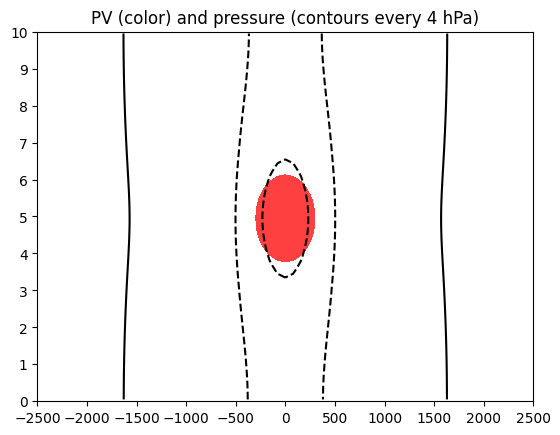

In [98]:
dp = 4 # in hPa
pcints = np.arange(-10*dp, 10*dp+dp, dp)
plt.contour(x*L/km, z*H/km, Pstar*phixy[:, jmid, :]/hPa, levels=pcints, colors='k')

PVcontour = 5e-7  # PVU

levels = [0, PVcontour, 100*PVcontour]
colors = ['white', 'red']


c = plt.contourf(x*L/km, z*H/km, EPVstar * pvxy[:, jmid, :],
                 levels=levels, colors=colors, alpha=0.75, zorder=0)

#plt.gca().set_aspect(1000/10)
plt.xticks(np.arange(-2500, 2500+500, 500))
plt.yticks(np.arange(0, 10+1, 1))
plt.title('PV (color) and pressure (contours every 4 hPa)')
plt.show()

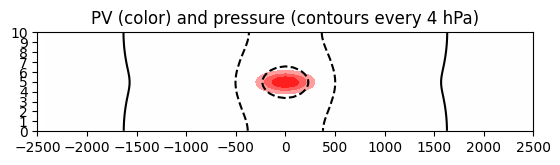

In [99]:
# same figure, scaled
dp = 4 # in hPa
pcints = np.arange(-10*dp, 10*dp+dp, dp)
plt.contour(x*L/km, z*H/km, Pstar*phixy[:, jmid, :]/hPa, levels=pcints, colors='k')

PVcontour = 5e-7  # PVU

clevs = np.arange(-2e-6, 2e-6+5e-7, 5e-7)
clevs = clevs[np.abs(clevs)>1e-16]

plt.contourf(x*L/km, z*H/km, EPVstar * pvxy[:, jmid, :],
                 clevs, cmap='bwr', alpha=1, zorder=0)

plt.gca().set_aspect(L/H)
plt.xticks(np.arange(-2500, 2500+500, 500))
plt.yticks(np.arange(0, 10+1, 1))
plt.title('PV (color) and pressure (contours every 4 hPa)')
plt.show()

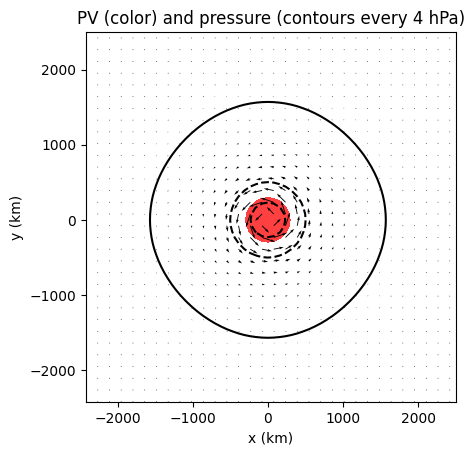

In [100]:
plt.figure()

# pressure contours

# option to plot in hPa or in equivalent hydrostatic height
dp = 4 # in hPa
#dh = 30; dp = Rhoref(zlev)*g*60/hPa; # pressure contours equal to dh height lines (in m)

pcints = np.arange(-10*dp, 10*dp+dp, dp)
plt.contour(x*L/km, y*L/km, Pstar*phixy[zlev, :, :]/hPa, levels=pcints,
            colors='k')

uxy = np.real(np.fft.ifft2(-1j * DY * np.squeeze(phisp[zlev, :, :])))
vxy = np.real(np.fft.ifft2(1j * DX * np.squeeze(phisp[zlev, :, :])))

skip = 2
plt.quiver(x[::skip]*L/km, y[::skip]*L/km,
           uxy[::skip, ::skip], vxy[::skip, ::skip], scale=50)

# PV contour

PVcontour = 5e-7  # PVU

levels = [0, PVcontour, 100*PVcontour]
colors = ['white', 'red']

plt.contourf(x * L / km, y * L / km, EPVstar * pvxy[zlev, :, :],
     levels=levels, colors=colors, alpha=0.75, zorder=0)

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.gca().set_aspect('equal')
plt.title('PV (color) and pressure (contours every {} hPa)'.format(dp))
plt.show()

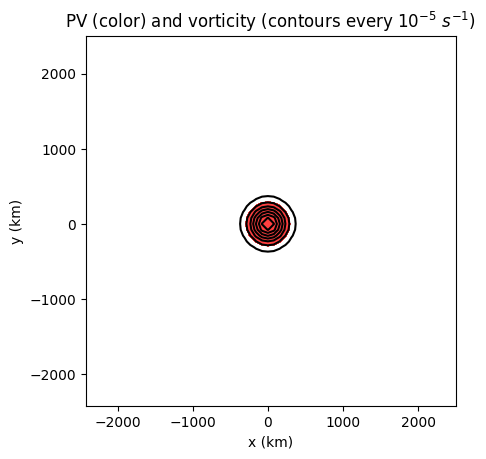

In [101]:
PVcontour = 5e-7  # PVU
levels = [0, PVcontour, 100*PVcontour]
colors = ['white', 'red']

# PV
plt.contourf(x * L / km, y * L / km, EPVstar * pvxy[zlev, :, :],
     levels=levels, colors=colors, alpha=0.75, zorder=0)


# Compute vorticity
vort = np.real(np.fft.ifft2(-(DX * DX + DY * DY) * phisp[zlev, :, :]))

# Add vorticity contours
dv = 4  # x 10^-5 s^-1
vcints = np.arange(-10 * dv, 11 * dv, dv) * 1e-5  # s^-1
plt.contour(x * L / km, y * L / km, Qstar * vort, levels=vcints, colors='k')

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('PV (color) and vorticity (contours every $10^{-5}$ $s^{-1}$)')

plt.gca().set_aspect('equal')
plt.show()


# calculate and plot omega

In [102]:
# basic-state wind
lamb = 3
#lamb = 0
Unot = -1.5

Ub = lamb * z + Unot # staggered grid
Ubu = lamb * zu + Unot # unstaggered grid

In [103]:
dpz = np.zeros((nlevs, Ny, Nx))
Q1 = np.zeros((nlevs, Ny, Nx))
Q2 = np.zeros((nlevs, Ny, Nx))
Qdiv = np.zeros((nlevs, Ny, Nx))

In [104]:
dtdx = np.zeros((nlevs, Ny, Nx))
dtdy = np.zeros((nlevs, Ny, Nx))
theta = np.zeros((nlevs, Ny, Nx))


In [105]:
# Q-vector
#   u,v derivative come straight from P field on staggered levels
#   theta derivatives are on unstaggered levels: average back to staggered

# compute theta on UNstaggered levels; u,v derivs on staggered levels
for k in np.arange(pmax):
  pxx = np.real(np.fft.ifft2( -DX*DX*np.squeeze(phisp[k,:,:])))
  pyy = np.real(np.fft.ifft2( -DY*DY*np.squeeze(phisp[k,:,:])))
  pxy = np.real(np.fft.ifft2( -DX*DY*np.squeeze(phisp[k,:,:])))
  if k < pmax-1:
    dpz[k,:,:] = (phixy[k+1,:,:] - phixy[k,:,:])/dz;

  # average d\phi/dz back to staggered levels where u,v derivatives are located
  if k == 0:
    dpzu = 0.5*(np.squeeze(dpz[k,:,:]) + thetabxy)
  elif k == pmax-1:
    dpzu = 0.5*(np.squeeze(dpz[k-1,:,:]) + thetatxy)
  else:
    dpzu = 0.5*(np.squeeze(dpz[k,:,:]) + np.squeeze(dpz[k-1,:,:]))

  # x,y derivatives of theta on unstaggered levels (including linear shear!)
  dtx = np.real(np.fft.ifft2(1j*DX*np.fft.fft2(dpzu)))
  dty = np.real(np.fft.ifft2(1j*DY*np.fft.fft2(dpzu))) - lamb

  dtdx[k, :, :] = dtx
  dtdy[k, :, :] = dty
  theta[k, :, :] = Thstar*dpzu


  # Q-vector on staggered levels
  Q1[k,:,:] = (pxy*dtx) - (pxx*dty)
  Q2[k,:,:] = (pyy*dtx) - (pxy*dty)

  # Q-vector divergence
  Q1sp = np.fft.fft2(np.squeeze(Q1[k,:,:]))
  Q2sp = np.fft.fft2(np.squeeze(Q2[k,:,:]))
  Qdiv[k,:,:] = 2*np.real(np.fft.ifft2(1j*DX*Q1sp + 1j*DY*Q2sp))
  if k == kmid:
    dtxplt = dtx
    pxxplt = pxx

# invert for w
lbcxy = np.zeros((Ny,Nx))
ubcxy = np.zeros((Ny,Nx))
idn = -1; # Dirichlet BC
wxy, wbxy, wtxy, wzbxy, wztxy = inv_laplacian(lbcxy,ubcxy,Qdiv,idn,dz,facx,facy)

In [106]:
uanom = np.zeros((nlevs, Ny, Nx))
vanom = np.zeros((nlevs, Ny, Nx))
for k in np.arange(pmax):
  uxy = np.real(np.fft.ifft2(-1j * DY * np.squeeze(phisp[k, :, :])))
  vxy = np.real(np.fft.ifft2(1j * DX * np.squeeze(phisp[k, :, :])))
  uanom[k, :, :] = uxy
  vanom[k, :, :] = vxy


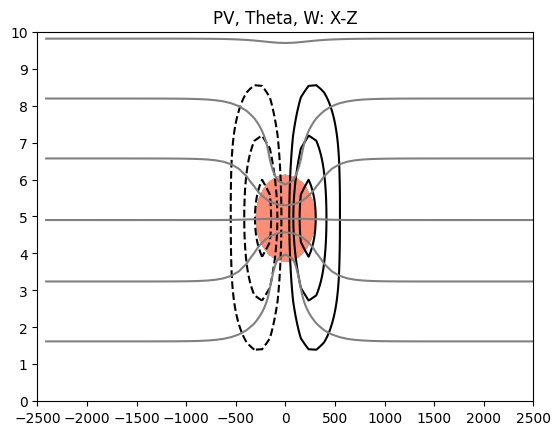

In [107]:
sfac = Wstar*100 # cm/s
wcint = np.arange(-10, 10+2, 2)
wcint = wcint[np.abs(wcint)>1e-6]
plt.contour(x*L/km, z*H/km, sfac*wxy[:, jmid, :], levels=wcint, colors='k')

thetatot = theta + Threfd[:, None, None] - lamb*y[None, :, None]*Thstar
tcint = np.arange(275, 355+5, 5)
plt.contour(x*L/km, z*H/km, thetatot[:, jmid, :], levels=tcint, colors='gray')

PVcontour = 5e-7  # PVU

c = plt.contourf(x*L/km, z*H/km, EPVstar * pvxy[:, jmid, :],
                 [PVcontour, 100*PVcontour], cmap='Reds', alpha=0.75, zorder=0)

#plt.gca().set_aspect(1000/10)
plt.xticks(np.arange(-2500, 2500+500, 500))
plt.yticks(np.arange(0, 10+1, 1))
plt.title('PV, Theta, W: X-Z')
plt.show()

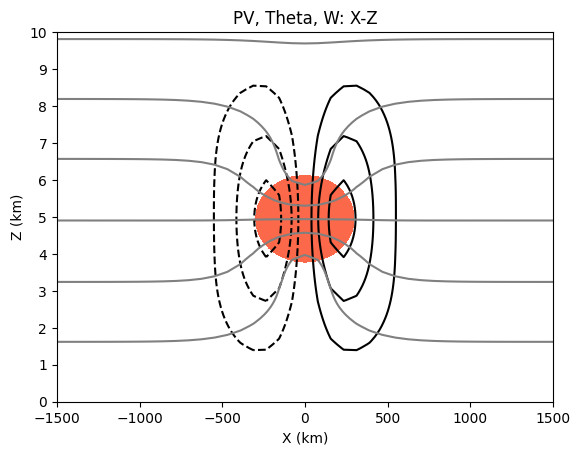

In [113]:
# smaller domain in x
sfac = Wstar*100 # cm/s
wcint = np.arange(-10, 10+2, 2)
wcint = wcint[np.abs(wcint)>1e-6]

plt.contour(x*L/km, z*H/km, sfac*wxy[:, jmid, :], levels=wcint, colors='k')

thetatot = theta + Threfd[:, None, None] - lamb*y[None, :, None]*Thstar
tcint = np.arange(275, 355+5, 5)
plt.contour(x*L/km, z*H/km, thetatot[:, jmid, :], levels=tcint, colors='gray')

PVcontour = 5e-7  # PVU

c = plt.contourf(x*L/km, z*H/km, EPVstar * pvxy[:, jmid, :],
                 [PVcontour, 100*PVcontour], cmap='Reds', alpha=1, zorder=0)

#plt.gca().set_aspect(L/H)
plt.xticks(np.arange(-2500, 2500+500, 500))
plt.yticks(np.arange(0, 10+1, 1))
plt.title('PV, Theta, W: X-Z')
plt.xlabel('X (km)')
plt.ylabel('Z (km)')
plt.xlim(-1500, 1500)
plt.show()

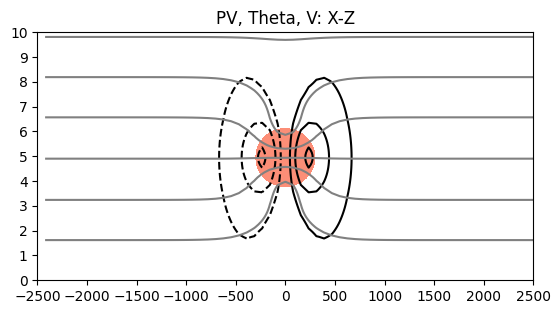

In [109]:
u = np.zeros((nlevs, Ny, Nx))
v = np.zeros((nlevs, Ny, Nx))
ubar = np.zeros((nlevs, Ny, Nx))

for zlev in range(nlevs):
  u[zlev, :, :] = np.real(np.fft.ifft2(-1j * DY * np.squeeze(phisp[zlev, :, :])))
  v[zlev, :, :] = np.real(np.fft.ifft2(1j * DX * np.squeeze(phisp[zlev, :, :])))

ucint = np.arange(-60, 60+6, 6)
ucint = ucint[np.abs(ucint)>1e-6]
plt.contour(x*L/km, z*H/km, U*v[:, jmid, :], levels=ucint, colors='k')

thetatot = theta + Threfd[:, None, None] - lamb*y[None, :, None]*Thstar
tcint = np.arange(275, 355+5, 5)
plt.contour(x*L/km, z*H/km, thetatot[:, jmid, :], levels=tcint, colors='gray')

PVcontour = 5e-7  # PVU

c = plt.contourf(x*L/km, z*H/km, EPVstar * pvxy[:, jmid, :],
                 [PVcontour, 100*PVcontour], cmap='Reds', alpha=0.75, zorder=0)

plt.gca().set_aspect(2500/10)
plt.xticks(np.arange(-2500, 2500+500, 500))
plt.yticks(np.arange(0, 10+1, 1))
plt.title('PV, Theta, V: X-Z')
plt.show()

# calculate and plot ageostrophic circulation

not sure if staggered variables should be one level smaller ... and what the range on the loops should be

unstaggered grid is one level larger
z starts at dz, zu starts at 0

w and theta: grid setup says unstaggered
             but w calc seems staggered
phi and PV: staggered

In [110]:
dwdzxy = np.zeros((nlevs, Ny, Nx))
chixy = np.zeros((nlevs, Ny, Nx))
uaxy = np.zeros((nlevs, Ny, Nx))
vaxy = np.zeros((nlevs, Ny, Nx))

for p in np.arange(pmax):
  if p == 0:
    dwdzxy = np.squeeze(wxy[p,:,:])*2/dz
  elif p == pmax-1:
    dwdzxy = -np.squeeze(wxy[p,:,:])*2/dz
  else:
    dwdzxy = np.squeeze((wxy[p,:,:] - wxy[p-1,:,:]))/dz

  dwdzsp = np.fft.fft2(dwdzxy)
  chisp = np.zeros((Ny,Nx)).astype(complex)
  for k in np.arange(2*kmax):
    for l in np.arange(2*lmax):
      ak, bl = get_waves(k,l,kmax,lmax,facx,facy)
      if ((k == 0) & (l == 0)): # no information on (x,y) mean
        chisp[l, k] = 0
      else:
        chisp[l, k] = dwdzsp[l, k]/(ak**2 + bl**2)

  chixy[p,:,:] = np.real(np.fft.ifft2(chisp))
  uasp = 1j*DX*chisp
  vasp = 1j*DY*chisp
  uaxy[p,:,:] = np.real(np.fft.ifft2(uasp))
  vaxy[p,:,:] = np.real(np.fft.ifft2(vasp))
  # mass continuity check
  #ux = real(np.fft.ifft2(1j*DX*uasp)); vy = real(np.fft.ifft2(1j*DY*vasp));
  #cc = np.amax(np.abs(ux+vy+dwdzxy)));
  #disp([int2str(p) ' maximum error in mass continuity check...' num2str(cc,4)]);


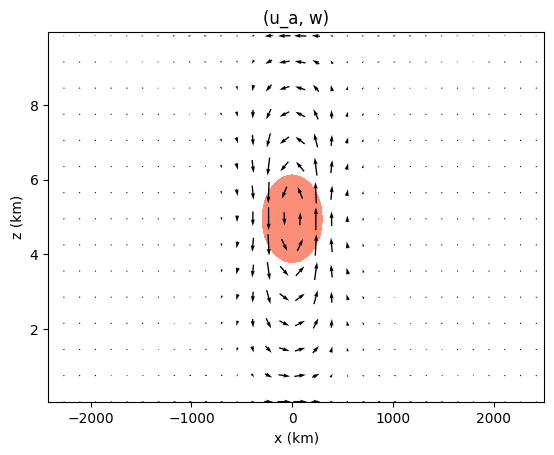

In [112]:
xskip = 2
zskip = 7
plt.quiver(x[::xskip]*L/km, z[::zskip]*H/km,
           uaxy[::zskip,jmid,::xskip],wxy[::zskip,jmid,::xskip],
           pivot='mid', scale=150)

PVcontour = 5e-7  # PVU

c = plt.contourf(x*L/km, z*H/km, EPVstar * pvxy[:, jmid, :],
                 [PVcontour, 100*PVcontour], cmap='Reds', alpha=0.75, zorder=0)

plt.xlabel('x (km)')
plt.ylabel('z (km)')
plt.title('(u_a, w)')

plt.show()